In [16]:
'''
KPrototype = https://medium.com/datadriveninvestor/k-prototype-in-clustering-mixed-attributes-e6907db91914
KMode = https://github.com/nicodv/kmodes
KPrototype = KMeans + KModes
Elbow, Silhouette = https://towardsdatascience.com/hierarchical-clustering-on-categorical-data-in-r-a27e578f2995
Cluster 3D plot: https://thatascience.com/learn-machine-learning/kmeans/
Interactive Cluster Plot: https://www.bigendiandata.com/2017-04-18-Jupyter_Customer360/
Subplot: 
https://stackoverflow.com/questions/3584805/in-matplotlib-what-does-the-argument-mean-in-fig-add-subplot111
https://stackoverflow.com/questions/48884280/plot-2-3d-surface-side-by-side-using-matplotlib
https://buzzrobot.com/dominant-colors-in-an-image-using-k-means-clustering-3c7af4622036
'''
#import pyhdb as db
from hdbcli import dbapi
import pandas as pd
import os
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
from matplotlib import style
from mpl_toolkits.mplot3d import Axes3D
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import numpy as np
import time
from scipy.spatial.distance import cosine
style.use("ggplot")

HOST = os.getenv("HOST")
PORT = os.getenv("PORT")
USER = os.getenv("USER")
PASSWORD = os.getenv("PASSWORD")
ORIG_SCHEMA = os.getenv("SCHEMA")

knttp = {}
lifnr = {}
flief = {}
matkl = {}
ekorg = {}
ekgrp = {}
CONFIDENCE_LEVEL = 0.95
NO_OF_CLUSTER = 15
THRESHOLD_PR_GROUP = 5

In [17]:
'''
Assumption:
    a) Account Assignment <> Blank Or Unassigned
    b) Status not in ‘RFQ created’, ‘PO created’, ‘Contract Created’,  and ‘Scheduling Agreement Created’
    c) PO is not yet assigned
    d) PR created by purchasing team (Direct/Indirect) --> ESTKZ in ('R', 'S')
    e) PR's not marked as deleted --> LOEKZ NOT IN ('X')

'''
def getOpenPRs():
    #connection = db.connect(HOST, PORT, USER, PASSWORD)
    connection = dbapi.connect(HOST, PORT, USER, PASSWORD)
    SQL_Query = pd.read_sql_query(
    """SELECT MANDT, BANFN, BNFPO, KNTTP, LIFNR, FLIEF, MATKL, EKORG, EKGRP
       FROM "SAPABAP1"."EBAN" 
       WHERE STATU NOT IN ('A', 'B', 'E', 'K', 'L') 
           AND EBELN = '' 
           AND ESTKZ in ('R', 'S') 
           AND KNTTP NOT IN ('','U') 
           AND LOEKZ NOT IN ('X')
           AND LFDAT >= 20180401 AND LFDAT <= 20181231 """, connection)
    
    originalData = pd.DataFrame(SQL_Query, columns=['MANDT', 'BANFN', 'BNFPO', 'KNTTP', 'LIFNR', 'FLIEF', 'MATKL', 'EKORG', 'EKGRP'])
    print(originalData.head())
    print(originalData.info())
    print(originalData.describe())
    return originalData 

def getFeatureList(data):
    colIndex = 0
    numericalColNames = []
    numericalColIndex = []
    categoricalColNames = []
    categoricalColIndex = []
    
    for col in data.columns:
        if (is_string_dtype(data[col])):
            categoricalColNames.append(col)
            categoricalColIndex.append(colIndex)
        elif (is_numeric_dtype(data[col])):
            numericalColNames.append(col)
            numericalColIndex.append(colIndex)
        colIndex = colIndex + 1 
    print("Numerical Columns") 
    print(numericalColNames)
    print("Categorical Columns") 
    print(categoricalColNames)
    return (numericalColNames, numericalColIndex, categoricalColNames, categoricalColIndex)    

def getBestKMode(data):
    distortions = []
    K = range(1,NO_OF_CLUSTER)
    for k in K:
        kmodes = KModes(n_clusters=k, init='Cao', n_init=5, verbose=2)
        kmodes.fit_predict(data)
        print("k:",k, " cost:", kmodes.cost_)
        distortions.append(kmodes.cost_)
    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.savefig("bestkmode.png", bbox_inches='tight', dpi=100)      
    plt.show()
    

def getBestKPrototype(data, categoricalColIndex):
    distortions = []
    K = range(1,NO_OF_CLUSTER)
    for k in K:
        kproto = KPrototypes(n_clusters=k, init='Cao', verbose=2)
        kproto.fit_predict(data)
        print("k:",k, " cost:", kproto.cost_)
        distortions.append(kproto.cost_)
    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.savefig("bestkprototype.png", bbox_inches='tight', dpi=100)    
    plt.draw()

def computeDataUniqueness(data):
    print("computing unique data list for KNTTP")
    knttp.update(getDataUniqueValue(data["KNTTP"].unique().tolist()))
    
    print("computing unique data list for LIFNR")
    lifnr.update(getDataUniqueValue(data["LIFNR"].unique().tolist()))
    
    print("computing unique data list for FLIEF")
    flief.update(getDataUniqueValue(data["FLIEF"].unique().tolist()))
    
    print("computing unique data list for MATKL")
    matkl.update(getDataUniqueValue(data["MATKL"].unique().tolist()))
    
    print("computing unique data list for EKORG")
    ekorg.update(getDataUniqueValue(data["EKORG"].unique().tolist()))
    
    print("computing unique data list for EKGRP")    
    ekgrp.update(getDataUniqueValue(data["EKGRP"].unique().tolist()))
    print(len(knttp), len(lifnr), len(flief), len(matkl), len(ekorg), len(ekgrp))

def getDataUniqueValue(data):
    dataMap = {}
    count = 0
    for value in data:
        dataMap[value] = count
        count = count + 1
    return dataMap
    
def executeKProtoTypeCluster(data, categoricalColIndex, k):
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=2)
    clusters = kproto.fit_predict(data, categorical=categoricalColIndex)
    # Print cluster centroids of the trained model.
    print("===============================================")
    centroids = kproto.cluster_centroids_
    print("Cluster Centroids:")
    print(centroids)     
    print("===============================================")        
    # Print training statistics
#     print(kproto.cost_)
#     print(kproto.n_iter_)
#     print(kproto.labels_)
    return (clusters, centroids)

def executeKModeCluster(data, k):
    kmodes = KModes(n_clusters=k, init='Cao', n_init=5, verbose=2)
    clusters = kmodes.fit_predict(data)
    # Print the cluster centroids
    print("===============================================")
    centroids = kmodes.cluster_centroids_
    print("Cluster Centroids:")
    print(centroids)     
    print("===============================================")        
    # Print training statistics
#     print(kmodes.cost_)
#     print(kmodes.n_iter_)
#     print(kmodes.labels_)
    return (clusters, centroids)

def replaceCentroidsWithUniqueness(centroids):
    cenSimilarity = []
    for cenRow in centroids:
        cenData = []
        cenData.append(knttp.get(cenRow[0]))
        cenData.append(lifnr.get(cenRow[1]))
        cenData.append(flief.get(cenRow[2]))
        cenData.append(matkl.get(cenRow[3]))
        cenData.append(ekorg.get(cenRow[4]))
        cenData.append(ekgrp.get(cenRow[5]))
        cenSimilarity.append(cenData)
    return cenSimilarity

def computeSimilarity(dataSim, data, cenSimilarity, clusters):
    cosine = []
    ''' Replace computed uniqueness value of categorical features '''
    for i in range(len(data)):
        dataSim.loc[i, "KNTTP"] = knttp.get(data.loc[i, "KNTTP"])
        dataSim.loc[i, "LIFNR"] = lifnr.get(data.loc[i, "LIFNR"])
        dataSim.loc[i, "FLIEF"] = flief.get(data.loc[i, "FLIEF"])
        dataSim.loc[i, "MATKL"] = matkl.get(data.loc[i, "MATKL"])
        dataSim.loc[i, "EKORG"] = ekorg.get(data.loc[i, "EKORG"])
        dataSim.loc[i, "EKGRP"] = ekgrp.get(data.loc[i, "EKGRP"])
        ''' Compute cosine similarity '''
        cosine.append(cosineSimilarity(dataSim.iloc[i], cenSimilarity[clusters[i]]))
#         sim = [dataSim.loc[i, "KNTTP"], dataSim.loc[i, "LIFNR"], dataSim.loc[i, "FLIEF"], dataSim.loc[i, "MATKL"], dataSim.loc[i, "EKORG"], dataSim.loc[i, "EKGRP"]]
#         cosine.append(cosineSimilarityLib(sim, cenSimilarity[clusters[i]]))
    return (cosine, dataSim)
    
def cosineSimilarity(a, b):
    cosValue = 0.0
    dot = np.dot(a, b)
    if(dot != 0 ):
        norma = np.linalg.norm(a)
        normb = np.linalg.norm(b)
        if(norma != 0 and normb != 0): 
            cosValue = dot / (norma * normb)
    return cosValue 

def cosineSimilarityLib(a, b):
    return (1 - cosine(a, b))

def groupClusteredPRs(originalData, dataCnv, clusters):
    filteredClusters = []    
    columnNames = ['KNTTP', 'LIFNR', 'FLIEF', 'MATKL', 'EKORG', 'EKGRP']
    filteredRows = pd.DataFrame(columns=columnNames)
    groupPRs = {}
    for i in range(len(originalData)):
        if(originalData.loc[i, "cosine"] >= CONFIDENCE_LEVEL):
            filteredRows.loc[i, 'KNTTP'] = dataCnv.loc[i, 'KNTTP']
            filteredRows.loc[i, 'LIFNR'] = dataCnv.loc[i, 'LIFNR']
            filteredRows.loc[i, 'FLIEF'] = dataCnv.loc[i, 'FLIEF']
            filteredRows.loc[i, 'MATKL'] = dataCnv.loc[i, 'MATKL']
            filteredRows.loc[i, 'EKORG'] = dataCnv.loc[i, 'EKORG']
            filteredRows.loc[i, 'EKGRP'] = dataCnv.loc[i, 'EKGRP']
            filteredClusters.append(clusters[i])            
            
            if(groupPRs.get(originalData.loc[i, "cluster"]) == None):
                clusterPRs = []
                clusterPRs.append(originalData.loc[i, "BANFN"])
                groupPRs[originalData.loc[i, "cluster"]] = clusterPRs
            else:
                clusterPRs = groupPRs.get(originalData.loc[i, "cluster"])
                if(originalData.loc[i, "BANFN"] not in clusterPRs):
                    clusterPRs.append(originalData.loc[i, "BANFN"])
    return (groupPRs, filteredRows, filteredClusters)

def filterPRs(groupPRs):
    filteredPRs = {}
    ''' Filter PRs with some threshold values '''
    for i in range(NO_OF_CLUSTER):
        if (groupPRs.get(i) != None and len(groupPRs.get(i)) >= THRESHOLD_PR_GROUP):
            filteredPRs[i] = groupPRs.get(i)
    return filteredPRs

def drawMultiplePlotClusters(dataSet, clusters, selectedPRs, selectedClusters, centroids):
    colors = [[255, 227, 3], #Yellow 
              [0, 139, 69], #Green
              [0, 0, 255]] #Blue
    #Plot the clusters obtained using k means
    ''' Position KNTTP = 0, LIFNR = 1, FLIEF = 2, MATKL = 3, EKORG = 4, EKGRP = 5, ESTKZ = 6 '''
    print(centroids[:, 0])
    print(centroids[:, 4])
    print(centroids[:, 5])
    
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle('Comparison plot of All clustered PRs Vs Selected PRs')
    ax1 = fig.add_subplot(221, projection='3d') #221=top left
    for cluster, data in zip(clusters, dataSet_norm):
        ax1.scatter(data[0], data[4], data[5], color = rgb_to_hex(colors[cluster]))
        
    ax1.scatter(centroids[:, 0],
                centroids[:, 4],
                centroids[:, 5],
                s = 50,
                marker='o',
                c='red',
                label='Centroids')
    
    ax1.set_title('PRs Clustering')
    ax1.set_xlabel('KNTTP')
    ax1.set_ylabel('EKORG')
    ax1.set_zlabel('EKGRP')
    ax1.legend(loc='upper left')
    
    ax2 = fig.add_subplot(223, projection='3d') #223=bottom left   
    for cluster, data in zip(selectedClusters, selectedPRs):
        ax2.scatter(data[0], data[4], data[5], color = rgb_to_hex(colors[cluster]))
    
    ax2.scatter(centroids[:, 0],
                centroids[:, 4],
                centroids[:, 5],
                s = 50,
                marker='o',
                c='red',
                label='Centroids')
    
    ax2.set_title('PRs Clustering')
    ax2.set_xlabel('KNTTP')
    ax2.set_ylabel('EKORG')
    ax2.set_zlabel('EKGRP')
    ax2.legend(loc='upper left')    
    
    plt.tight_layout()
    plt.savefig("prrec.png", bbox_inches='tight', dpi=100)    
    plt.draw()

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))

In [18]:
''' Step1: Get all open PRs '''
print('Getting open PRs....')
originalData = getOpenPRs()
data = originalData.copy()
''' We don't need primary keys for computing clusters '''
data.drop(['MANDT', 'BANFN', 'BNFPO'], axis = 1, inplace = True)        

Getting open PRs....
  MANDT       BANFN  BNFPO KNTTP       LIFNR FLIEF     MATKL EKORG EKGRP
0   100  0518538842  00010     K                    25270100  KR01   AJA
1   100  0522476266  00010     P                    1902X100         OC5
2   100  0517585602  00030     K                    25050600         UWE
3   100  0512703893  00030     F  0000291413        36410101  BE25   OAG
4   100  0512331530  00010     K  0001581915        25169000  DE1M   DUV
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3860 entries, 0 to 3859
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   MANDT   3860 non-null   object
 1   BANFN   3860 non-null   object
 2   BNFPO   3860 non-null   object
 3   KNTTP   3860 non-null   object
 4   LIFNR   3860 non-null   object
 5   FLIEF   3860 non-null   object
 6   MATKL   3860 non-null   object
 7   EKORG   3860 non-null   object
 8   EKGRP   3860 non-null   object
dtypes: object(9)
memory usage: 271.5+ 

In [19]:
''' Step2: Get categorical and numerical features '''
print('Checking numerical/categorical features....')    
featureList = getFeatureList(data)
numericalColNames = featureList[0]
numericalColIndex = featureList[1]
categoricalColNames = featureList[2]
categoricalColIndex = featureList[3]

Checking numerical/categorical features....
Numerical Columns
[]
Categorical Columns
['KNTTP', 'LIFNR', 'FLIEF', 'MATKL', 'EKORG', 'EKGRP']


In [20]:
''' Step3: Compute categorical data uniqueness '''
print('Compute categorical data uniqueness....')
computeDataUniqueness(data)

Compute categorical data uniqueness....
computing unique data list for KNTTP
computing unique data list for LIFNR
computing unique data list for FLIEF
computing unique data list for MATKL
computing unique data list for EKORG
computing unique data list for EKGRP
10 749 375 482 126 364


Depict elbow method to detect best K for clustering.....
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 14269.0
k: 1  cost: 14269.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 60, cost: 13246.0
Run 1, iteration: 2/100, moves: 0, cost: 13246.0
k: 2  cost: 13246.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 62, cost: 12411.0
Run 1, iteration: 2/100, moves: 0, cost: 12411.0
k: 3  cost: 12411.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, itera

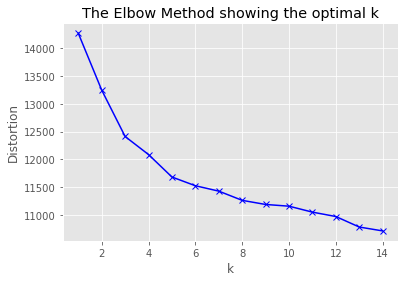

In [21]:
'''
Find best K using elbow method
'''
prData = (originalData, data, (numericalColNames, numericalColIndex, categoricalColNames, categoricalColIndex))
originalData = prData[0]
data = prData[1]
featureList = prData[2]
numericalColNames = featureList[0]
numericalColIndex = featureList[1]
categoricalColNames = featureList[2]
categoricalColIndex = featureList[3]
print("Depict elbow method to detect best K for clustering.....")
if (len(numericalColNames) > 0):
    ''' Combination of numerical and categorical '''
    getBestKPrototype(data, categoricalColIndex)
else:
    getBestKMode(data)


In [22]:
noOfCluster = 3
''' Step4: Cluster PRs data '''
print('NO_OF_CLUSTER', noOfCluster)
print('CLuster PRs....')
if (len(numericalColNames) > 0):
    clustersColn = executeKProtoTypeCluster(data, categoricalColIndex, noOfCluster)
else:
    clustersColn = executeKModeCluster(data, noOfCluster)
clusters = clustersColn[0]
centroids = clustersColn[1]

NO_OF_CLUSTER 3
CLuster PRs....
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 62, cost: 12411.0
Run 1, iteration: 2/100, moves: 0, cost: 12411.0
Cluster Centroids:
[['K' '' '' '25050600' '' 'QCN']
 ['P' '' '' '23179000' 'US01' 'OAH']
 ['P' '' '' '23110000' '' 'SP5']]


In [23]:
''' Step5: Replace categorical values in centroids with computed uniqueness values for measuring similarity '''
cenSimilarity = replaceCentroidsWithUniqueness(centroids)
print(cenSimilarity)

[[0, 0, 0, 2, 1, 33], [1, 0, 0, 68, 4, 13], [1, 0, 0, 371, 1, 110]]


In [24]:
''' Step6: Update categorical data for computing similarity  '''
print('.......... Computing cosine similarity ............')
dataSim = data.copy()
cosineSimilarity = computeSimilarity(dataSim, data, cenSimilarity, clusters)
cosine = cosineSimilarity[0]
dataCnv = cosineSimilarity[1]

.......... Computing cosine similarity ............


In [25]:
''' Add additional columns to original data '''
originalData['cosine'] = cosine
originalData['cluster'] = clusters
print(originalData.head())

''' Step7: Group all clustered PRs with certain confidence level '''
print('Grouping PRs with confidence level > 95% ...')
groupedPRs = groupClusteredPRs(originalData, dataCnv, clusters)
groupPRs = groupedPRs[0]
selectedPRs = groupedPRs[1]
selectedClusters =  groupedPRs[2]    
print("Grouped PRs:")
print(groupPRs)

  MANDT       BANFN  BNFPO KNTTP       LIFNR FLIEF     MATKL EKORG EKGRP  \
0   100  0518538842  00010     K                    25270100  KR01   AJA   
1   100  0522476266  00010     P                    1902X100         OC5   
2   100  0517585602  00030     K                    25050600         UWE   
3   100  0512703893  00030     F  0000291413        36410101  BE25   OAG   
4   100  0512331530  00010     K  0001581915        25169000  DE1M   DUV   

     cosine  cluster  
0  0.000000        0  
1  0.624085        2  
2  0.715531        0  
3  0.622577        0  
4  0.644497        0  
Grouping PRs with confidence level > 95% ...
Grouped PRs:
{2: ['0519262498', '0522877227', '0522271731', '0523043995', '0519167294', '0506802604', '1073615405', '0506801975', '0517366002', '1073489344', '0517366061', '0518637230', '0512434171', '0522204688', '0514916854', '0512552904', '0498759259', '0497817912', '0497817915', '0521830968', '1073699004', '0498191917', '0523040723', '0522459938', '05155

In [26]:
''' Step9: Filter PRs based on certain threshold value on grouped PR's '''
print('Filtering PRs with cluster having more than 5 PRs ...')
filteredPRs = filterPRs(groupPRs)
print("Filtered PRs")
print(filteredPRs)

Filtering PRs with cluster having more than 5 PRs ...
Filtered PRs
{0: ['0522488878', '1073553039', '0519638286', '0451894606', '0517760667', '0517760668', '1073702775', '0513293403', '0522460107', '0522493726', '1073073007', '0519447782', '0523059705', '0510762117', '0487018130', '0516995462', '1073702771', '0520684702', '0522444042', '0515996661', '0517738531', '0520863337', '0522920180', '0521053608', '0521831443', '0521022557', '0521816616', '0520871673'], 1: ['0517421589', '0522299832', '1073683156', '1073601517', '0499914863', '0519791358', '0517240419', '1073693829', '1073676456', '0522464850', '0519447720', '1073605196', '1073702468', '1073697896', '1073697897', '0522118630', '0522034167', '0522118956', '0522119643', '0522459937', '1073697894', '0522459939'], 2: ['0519262498', '0522877227', '0522271731', '0523043995', '0519167294', '0506802604', '1073615405', '0506801975', '0517366002', '1073489344', '0517366061', '0518637230', '0512434171', '0522204688', '0514916854', '0512552

[0. 1. 1.]
[0. 1. 0.]
[0.20618557 0.         1.        ]


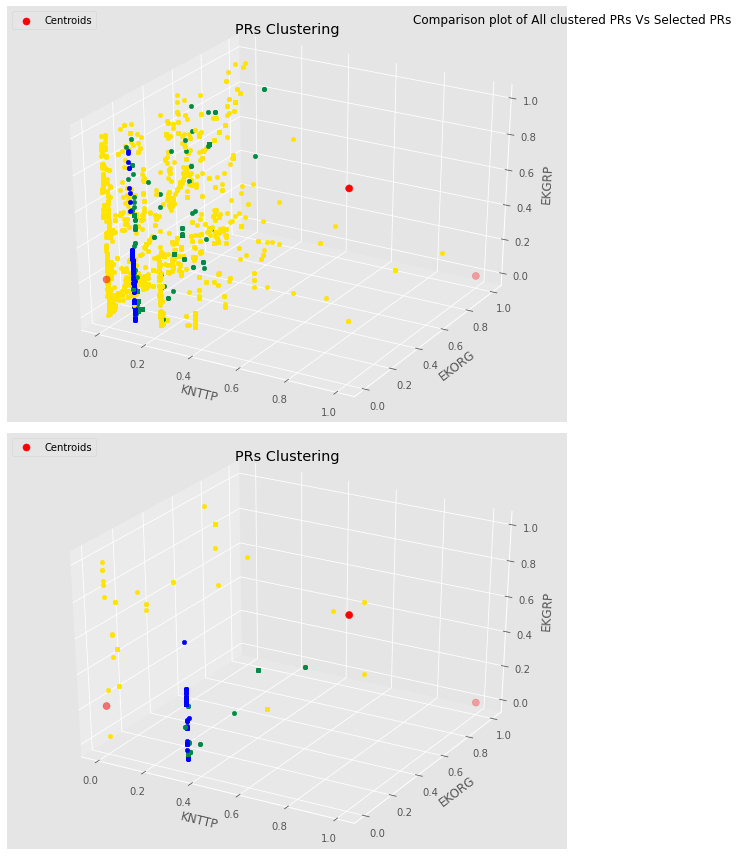

In [27]:
''' Plot cluster graphs '''
#Data normalozation
from sklearn.preprocessing import MinMaxScaler

dataSet = np.array(dataCnv)
# fit scaler on training data
norm = MinMaxScaler().fit(dataSet)

# transform training data
dataSet_norm = norm.transform(dataSet)

selectedPRsData = np.array(selectedPRs)
norm = MinMaxScaler().fit(selectedPRsData)
selectedPRsData_norm = norm.transform(selectedPRsData)

similarity = np.array(cenSimilarity)
norm = MinMaxScaler().fit(similarity)
cenSimilarity_norm = norm.transform(similarity)

drawMultiplePlotClusters(dataSet_norm, clusters, selectedPRsData_norm, selectedClusters, cenSimilarity_norm)